In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import requests
from io import BytesIO
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/UAS-AI/Knee-Dataset/'
if os.path.exists(data_path):
    print("Path exists")
else:
    print("Path does not exist")

Path exists


In [ ]:
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))
print(label_dict)
print(categories)
print(labels)

{'Moderate': 0, 'Doubtful': 1, 'Severe': 2, 'Mild': 3, 'Normal': 4}
['Moderate', 'Doubtful', 'Severe', 'Mild', 'Normal']
[0, 1, 2, 3, 4]


In [ ]:
img_size = 128
data = []
label = []
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

In [ ]:
data = np.array(data) / 255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
label = np.array(label)
new_label = to_categorical(label)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(data)

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=data.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 32)        1

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=250, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/250
42/42 [==============================] - 13s 85ms/step - loss: 2.3861 - accuracy: 0.2705 - val_loss: 2.2049 - val_accuracy: 0.3121
Epoch 2/250
42/42 [==============================] - 3s 62ms/step - loss: 2.1481 - accuracy: 0.2818 - val_loss: 2.1347 - val_accuracy: 0.3364
Epoch 3/250
42/42 [==============================] - 4s 97ms/step - loss: 2.0550 - accuracy: 0.3030 - val_loss: 2.0062 - val_accuracy: 0.3364
Epoch 4/250
42/42 [==============================] - 3s 61ms/step - loss: 1.9874 - accuracy: 0.3227 - val_loss: 1.9839 - val_accuracy: 0.2879
Epoch 5/250
42/42 [==============================] - 3s 63ms/step - loss: 1.8891 - accuracy: 0.3227 - val_loss: 1.9209 - val_accuracy: 0.2879
Epoch 6/250
42/42 [==============================] - 3s 67ms/step - loss: 1.8469 - accuracy: 0.3227 - val_loss: 1.8622 - val_accuracy: 0.2879
Epoch 7/250
42/42 [==============================] - 4s 89ms/step - loss: 1.7932 - accuracy: 0.3114 - val_loss: 1.8155 - val_accuracy: 0.2879
Epoch

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


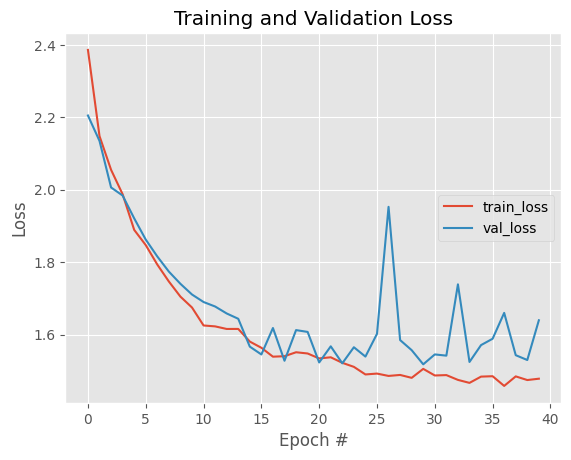

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="center right")
plt.savefig("CNN_Model_Loss")

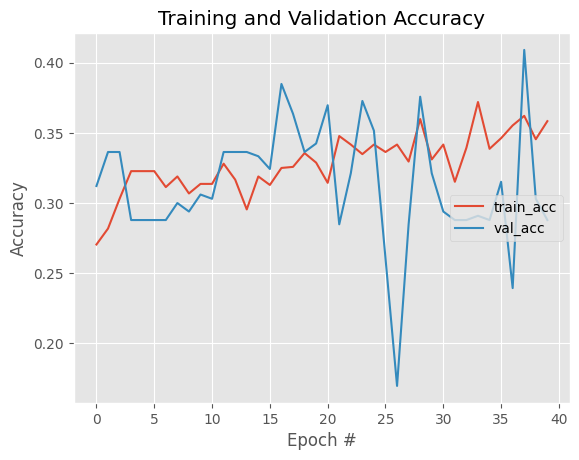

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model_Accuracy")

In [ ]:
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("test loss:", val_loss, '%')
print("test accuracy:", val_accuracy, "%")

test loss: 1.5177078247070312 %
test accuracy: 0.32121211290359497 %


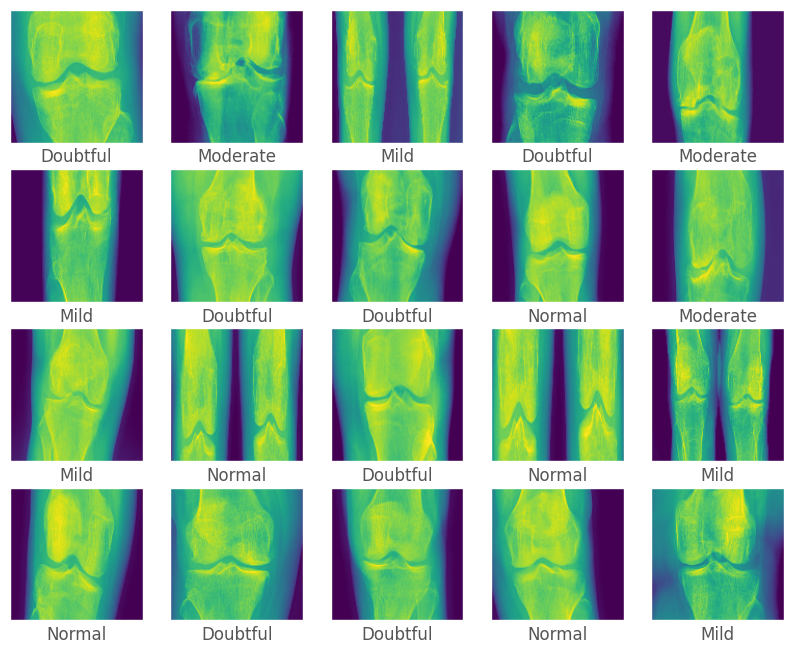

In [ ]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

In [ ]:
def preprocess_image_from_path(image_path, img_size=128):
    img = Image.open(image_path).convert('L')
    img = img.resize((img_size, img_size))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

In [ ]:
image_path = '/content/drive/MyDrive/KNEE_X-RAY/download.jpeg'

In [ ]:
img_single = preprocess_image_from_path(image_path)

In [ ]:
predictions_single = model.predict(img_single)
predicted_class = np.argmax(predictions_single)

1/1 [==============================] - 0s 294ms/step


In [ ]:
categories = ['Normal', 'Doubtful', 'Mid', 'Moderate', 'Severe']

In [ ]:
print('A.I predicts:', categories[predicted_class])

A.I predicts: Severe


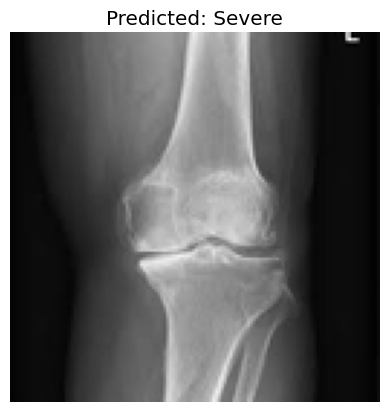

In [ ]:
plt.imshow(np.squeeze(img_single), cmap='gray')
plt.title(f'Predicted: {categories[predicted_class]}')
plt.axis('off')
plt.show()

11/11 [==============================] - 0s 8ms/step


<Figure size 640x480 with 0 Axes>

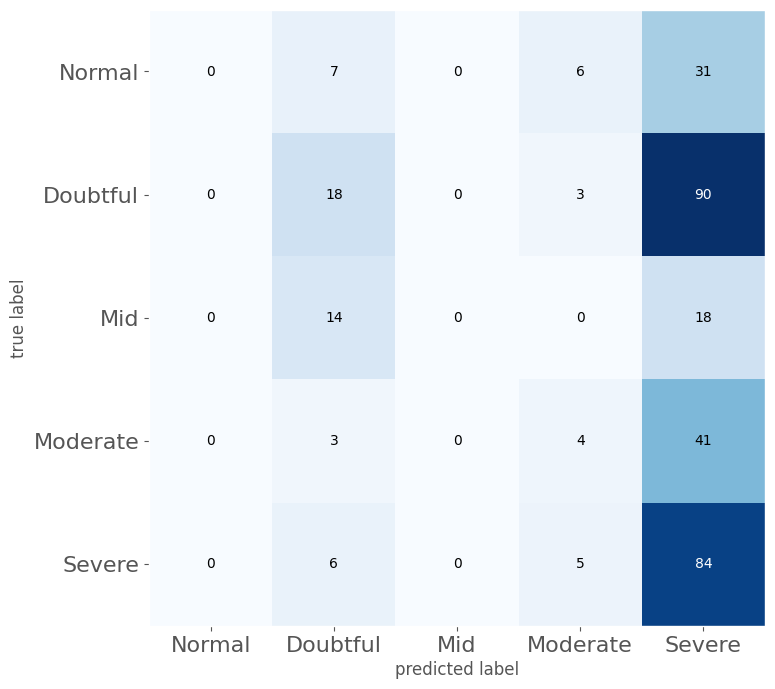

In [ ]:
test_labels = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)

cm = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(5), ['Normal', 'Doubtful', 'Mid', 'Moderate', 'Severe'], fontsize=16)
plt.yticks(range(5), ['Normal', 'Doubtful', 'Mid', 'Moderate', 'Severe'], fontsize=16)
plt.show()